<a href="https://colab.research.google.com/github/mafif21/dietin-app/blob/main/model/inceptionv3/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install import_ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00


In [ ]:
import import_ipynb
import shutil
import tensorflow as tf
from tensorflow.keras import layers

### Data

In [ ]:
from google.colab import drive
# drive.mount('/content/gdrive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
shutil.copyfile('/content/drive/MyDrive/Colab Notebooks/data_etl_v2.ipynb', '/content/data_etl.ipynb')

'/content/data_etl.ipynb'

In [ ]:
from data_etl import IndonesianFoodDataset

data = IndonesianFoodDataset(dataset_path='/content/drive/MyDrive/Dataset/indonesian_foods_v3', split_size=(0.8, 0.1, 0.1))
train_set, val_set, test_set = data.load_data(target_size=(299,299),
                                    rotation_range = 35,
                                    width_shift_range = 0.25,
                                    height_shift_range = 0.25,
                                    shear_range = 0.25,
                                    zoom_range = 0.15,
                                    brightness_range=[0.7, 1.2],
                                    horizontal_flip = True,
                                    # vertical_flip = True,
                                    batch_size = 32)

importing Jupyter notebook from data_etl.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ayam_bakar: 922
bakso: 737
bebek_goreng: 472
burger: 728
gado_gado: 764
gudeg: 751
ikan_bakar: 653
martabak_manis: 571
martabak_telor: 606
nasi_goreng: 606
omelette: 727
pempek: 575
rendang: 782
sate: 1129
sayur_asem: 597
semur_jengkol: 550


Copying files: 11170 files [00:04, 2581.99 files/s]


Found 8818 images belonging to 16 classes.
Found 1104 images belonging to 16 classes.
Found 1119 images belonging to 16 classes.


In [ ]:
import os
from collections import defaultdict

# Assuming train_set is a DirectoryIterator
filepaths = train_set.filepaths

# Create a dictionary to store the count for each folder
folder_counts = defaultdict(int)

# Count the number of images in each folder
for filepath in filepaths:
    folder = os.path.dirname(filepath)
    folder_counts[folder] += 1

# Print the counts for each folder
print("Number of images in each folder:")
for folder, count in folder_counts.items():
    print(f"{folder}: {count} images")


Number of images in each folder:
/content/tmp_set/train/ayam_bakar: 651 images
/content/tmp_set/train/bakso: 589 images
/content/tmp_set/train/bebek_goreng: 377 images
/content/tmp_set/train/burger: 560 images
/content/tmp_set/train/gado_gado: 809 images
/content/tmp_set/train/gudeg: 600 images
/content/tmp_set/train/omelette: 581 images
/content/tmp_set/train/rendang: 625 images
/content/tmp_set/train/salad: 840 images
/content/tmp_set/train/sate: 903 images
/content/tmp_set/train/sayur_asem: 477 images
/content/tmp_set/train/semur_jengkol: 440 images


### InceptionV3

In [ ]:
import urllib.request
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(
    inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (299, 299, 3),
                                include_top = False,
                                weights = local_weights_file,
                                pooling='max'
                                )

In [ ]:
import urllib.request
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (299, 299, 3),
                                include_top = False,
                                weights = 'imagenet',
                                pooling = 'max'
                                )

87910968/87910968 [==============================] - 1s 0us/step


### Freeze Layer

In [ ]:
tf.random.set_seed(24)

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = True

In [ ]:
for layer in pre_trained_model.layers:
  if layer.name == 'mixed5':
    break
  layer.trainable = False

### Model

In [ ]:
pre_output = pre_trained_model.get_layer('block6d_se_reduce').output
x = tf.keras.layers.Flatten()(pre_output)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(90, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0015))(x)
x = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)

In [ ]:
pre_output = pre_trained_model.get_layer('activation_153').output

x = tf.keras.layers.Flatten()(pre_output)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)

In [ ]:
pre_output = pre_trained_model.get_layer('activation_153').output

x = tf.keras.layers.Conv2D(100, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(pre_output)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Dropout(0.5)(x)

# x = tf.keras.layers.Conv2D(100, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = tf.keras.layers.MaxPool2D((2,2))(x)
# x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0005), # better di atas 5e-5 kayanya
              # optimizer=tf.keras.optimizers.RMSprop(0.001), #'RMSProp',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalization_94

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_118 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_118[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalizati

### Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

checkpoint_path = "/content/drive/MyDrive/model/model_checkpoint_activation_153_v3_A.h5"
# checkpoint_path = "/content/drive/MyDrive/Machine Learning/Checkpoint/model_checkpoint_activation_153_v5.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_best_only=True)

In [ ]:
class Callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] > 0.93 and logs['val_accuracy'] > 90:
            print("\nAccuracy reached 93% and validation acccuracy reached 90%! Stopping training.")
            self.model.stop_training = True

stop_callback = Callbacks()

In [ ]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_log_activation_153_v3_A.csv', separator=',', append=True)

### Save

In [ ]:
model.save('/content/drive/MyDrive/model/model_activation_153_v2_A.h5')
model.save('/content/drive/MyDrive/model/model_activation_153_v2_A.keras')

### Training

In [ ]:
# activation_153 v3 A
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
  1/276 [..............................] - ETA: 5:13 - loss: 3.0864 - accuracy: 0.1250

UnknownError: ignored

### V2

In [ ]:
# activation_153 v2 A (21)
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model_activation_153_v2_A.h5')

loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(0.00002),
                    metrics = ['accuracy'])

new_history = loaded_model.fit(train_set,
                               callbacks = [csv_logger, checkpoint_callback],
                               validation_data = val_set,
                               epochs = 15
                               )

Epoch 1/15
306/306 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.9356

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


306/306 [==============================] - 328s 1s/step - loss: 0.4436 - accuracy: 0.9356 - val_loss: 0.4949 - val_accuracy: 0.9216
Epoch 2/15
306/306 [==============================] - 325s 1s/step - loss: 0.4514 - accuracy: 0.9340 - val_loss: 0.4926 - val_accuracy: 0.9237
Epoch 3/15
306/306 [==============================] - 318s 1s/step - loss: 0.4315 - accuracy: 0.9373 - val_loss: 0.4975 - val_accuracy: 0.9248
Epoch 4/15
306/306 [==============================] - 319s 1s/step - loss: 0.4285 - accuracy: 0.9394 - val_loss: 0.4885 - val_accuracy: 0.9248
Epoch 5/15
306/306 [==============================] - 319s 1s/step - loss: 0.4190 - accuracy: 0.9420 - val_loss: 0.4857 - val_accuracy: 0.9237
Epoch 6/15
306/306 [==============================] - 324s 1s/step - loss: 0.4094 - accuracy: 0.9427 - val_loss: 0.4932 - val_accuracy: 0.9216
Epoch 7/15
306/306 [==============================] - 329s 1s/step - loss: 0.4182 - accuracy: 0.9423 - val_loss: 0.4978 - val_accuracy: 0.9237
Epoch 8/15

In [ ]:
# activation_153 v2 A
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
306/306 [==============================] - ETA: 0s - loss: 2.6494 - accuracy: 0.2059

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


306/306 [==============================] - 353s 1s/step - loss: 2.6494 - accuracy: 0.2059 - val_loss: 1.9773 - val_accuracy: 0.4901
Epoch 2/20
306/306 [==============================] - 322s 1s/step - loss: 1.8636 - accuracy: 0.4932 - val_loss: 1.1288 - val_accuracy: 0.7503
Epoch 3/20
306/306 [==============================] - 319s 1s/step - loss: 1.3807 - accuracy: 0.6554 - val_loss: 0.8789 - val_accuracy: 0.8224
Epoch 4/20
306/306 [==============================] - 317s 1s/step - loss: 1.1723 - accuracy: 0.7275 - val_loss: 0.7756 - val_accuracy: 0.8485
Epoch 5/20
306/306 [==============================] - 317s 1s/step - loss: 1.0371 - accuracy: 0.7728 - val_loss: 0.7136 - val_accuracy: 0.8704
Epoch 6/20
306/306 [==============================] - 320s 1s/step - loss: 0.9470 - accuracy: 0.8020 - val_loss: 0.6872 - val_accuracy: 0.8652
Epoch 7/20
306/306 [==============================] - 327s 1s/step - loss: 0.8793 - accuracy: 0.8213 - val_loss: 0.6780 - val_accuracy: 0.8840
Epoch 8/20

Text(0.5, 1.0, 'Model Loss')

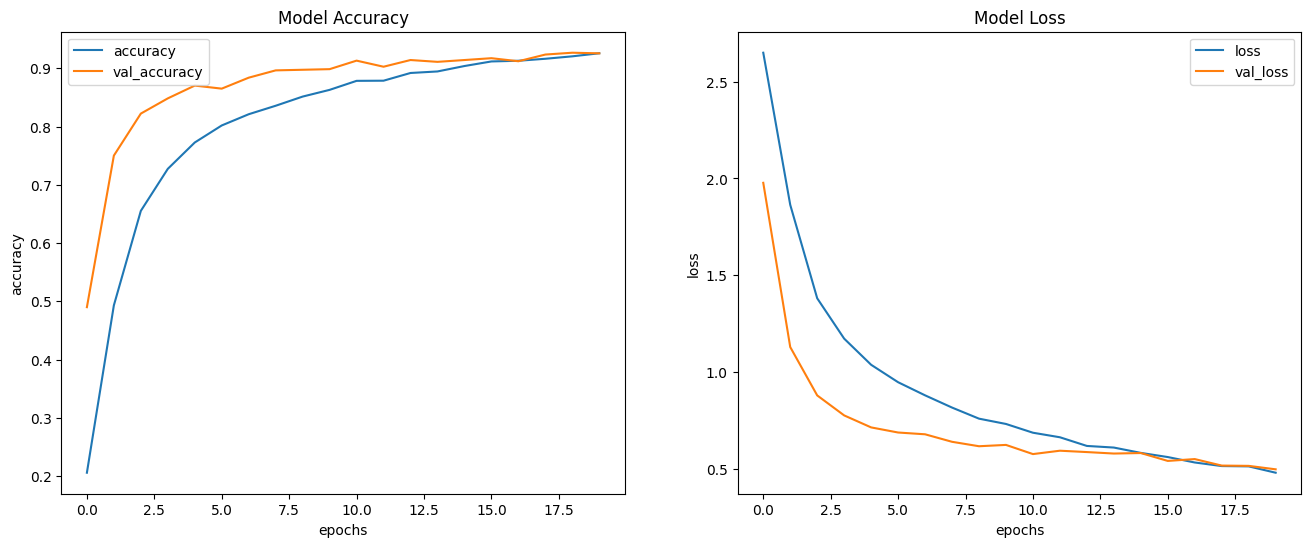

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.title('Model Loss')

### Cleaned New

In [ ]:
# activation_153 new v3 (27)
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model_activation_153_new_v3(21-27).h5')

loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(0.00004),
                    metrics = ['accuracy'])

new_history = loaded_model.fit(train_set,
                               callbacks = [csv_logger, checkpoint_callback],
                               validation_data = val_set,
                               epochs = 9
                               )

Epoch 1/9
261/261 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.9134

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


261/261 [==============================] - 341s 1s/step - loss: 0.5563 - accuracy: 0.9134 - val_loss: 0.5422 - val_accuracy: 0.9164
Epoch 2/9
261/261 [==============================] - 314s 1s/step - loss: 0.5374 - accuracy: 0.9150 - val_loss: 0.5344 - val_accuracy: 0.9215
Epoch 3/9
261/261 [==============================] - 325s 1s/step - loss: 0.5331 - accuracy: 0.9155 - val_loss: 0.5164 - val_accuracy: 0.9215
Epoch 4/9
261/261 [==============================] - 317s 1s/step - loss: 0.5144 - accuracy: 0.9197 - val_loss: 0.5250 - val_accuracy: 0.9195
Epoch 5/9
261/261 [==============================] - 313s 1s/step - loss: 0.5094 - accuracy: 0.9182 - val_loss: 0.5228 - val_accuracy: 0.9215
Epoch 6/9
261/261 [==============================] - 312s 1s/step - loss: 0.5020 - accuracy: 0.9211 - val_loss: 0.5076 - val_accuracy: 0.9205
Epoch 7/9
261/261 [==============================] - 315s 1s/step - loss: 0.4899 - accuracy: 0.9224 - val_loss: 0.5127 - val_accuracy: 0.9215
Epoch 8/9
261/26

In [ ]:
loaded_model.evaluate(test_set)

33/33 [==============================] - 7s 214ms/step - loss: 0.4953 - accuracy: 0.9282


[0.495295912027359, 0.9282103180885315]

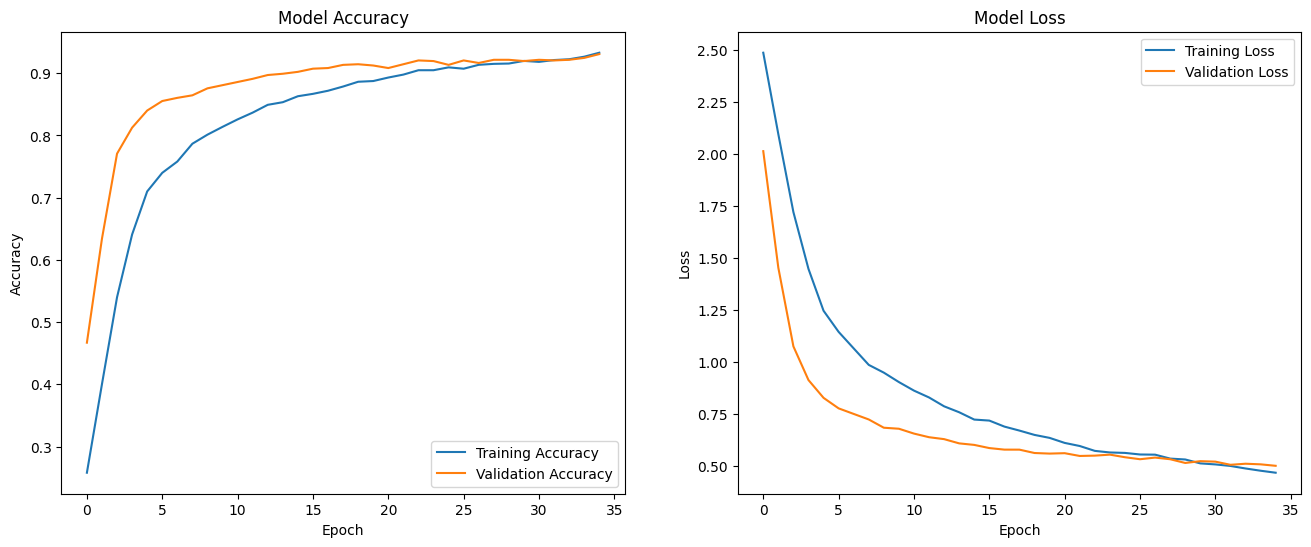

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_data = pd.read_csv('/content/training_log_activation_153_new_v3.csv')

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.title('Model Accuracy')
plt.plot(log_data['epoch'], log_data['accuracy'], label='Training Accuracy')
plt.plot(log_data['epoch'], log_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Model Loss')
plt.plot(log_data['epoch'], log_data['loss'], label='Training Loss')
plt.plot(log_data['epoch'], log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# activation_153 new v3 (21)
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model_activation_153_new_v3.h5')

loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(0.00003),
                    metrics = ['accuracy'])

new_history = loaded_model.fit(train_set,
                               callbacks = [csv_logger, checkpoint_callback],
                               validation_data = val_set,
                               epochs = 10
                               )

Epoch 1/10
261/261 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.8930

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


261/261 [==============================] - 345s 1s/step - loss: 0.6128 - accuracy: 0.8930 - val_loss: 0.5634 - val_accuracy: 0.9083
Epoch 2/10
261/261 [==============================] - 332s 1s/step - loss: 0.5979 - accuracy: 0.8977 - val_loss: 0.5501 - val_accuracy: 0.9144
Epoch 3/10
261/261 [==============================] - 337s 1s/step - loss: 0.5745 - accuracy: 0.9048 - val_loss: 0.5517 - val_accuracy: 0.9205
Epoch 4/10
261/261 [==============================] - 325s 1s/step - loss: 0.5669 - accuracy: 0.9048 - val_loss: 0.5564 - val_accuracy: 0.9195
Epoch 5/10
261/261 [==============================] - 323s 1s/step - loss: 0.5647 - accuracy: 0.9094 - val_loss: 0.5439 - val_accuracy: 0.9134
Epoch 6/10
261/261 [==============================] - 326s 1s/step - loss: 0.5572 - accuracy: 0.9072 - val_loss: 0.5344 - val_accuracy: 0.9205
Epoch 7/10
185/261 [====================>.........] - ETA: 1:33 - loss: 0.5601 - accuracy: 0.9072

In [ ]:
# activation_153 new v3
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
261/261 [==============================] - ETA: 0s - loss: 2.4887 - accuracy: 0.2579

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


261/261 [==============================] - 320s 1s/step - loss: 2.4887 - accuracy: 0.2579 - val_loss: 2.0155 - val_accuracy: 0.4669
Epoch 2/20
261/261 [==============================] - 319s 1s/step - loss: 2.0970 - accuracy: 0.4003 - val_loss: 1.4550 - val_accuracy: 0.6340
Epoch 3/20
261/261 [==============================] - 313s 1s/step - loss: 1.7225 - accuracy: 0.5399 - val_loss: 1.0769 - val_accuracy: 0.7706
Epoch 4/20
261/261 [==============================] - 317s 1s/step - loss: 1.4494 - accuracy: 0.6408 - val_loss: 0.9150 - val_accuracy: 0.8124
Epoch 5/20
261/261 [==============================] - 315s 1s/step - loss: 1.2483 - accuracy: 0.7099 - val_loss: 0.8295 - val_accuracy: 0.8400
Epoch 6/20
261/261 [==============================] - 320s 1s/step - loss: 1.1467 - accuracy: 0.7398 - val_loss: 0.7789 - val_accuracy: 0.8552
Epoch 7/20
261/261 [==============================] - 333s 1s/step - loss: 1.0673 - accuracy: 0.7580 - val_loss: 0.7522 - val_accuracy: 0.8603
Epoch 8/20

### Cleaned

In [ ]:
# activation_153 cleaned v4 (21)
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model_activation_153_cleaned_v4.h5')

loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(0.00001),
                    metrics = ['accuracy'])

new_history = loaded_model.fit(train_set,
                               callbacks = [csv_logger, checkpoint_callback],
                               validation_data = val_set,
                               epochs = 10
                               )

Epoch 1/10
166/166 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.9219

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 255s 1s/step - loss: 0.5319 - accuracy: 0.9219 - val_loss: 0.5924 - val_accuracy: 0.9164
Epoch 2/10
166/166 [==============================] - 235s 1s/step - loss: 0.5261 - accuracy: 0.9243 - val_loss: 0.5874 - val_accuracy: 0.9239
Epoch 3/10
166/166 [==============================] - 234s 1s/step - loss: 0.5127 - accuracy: 0.9279 - val_loss: 0.5869 - val_accuracy: 0.9218
Epoch 4/10
166/166 [==============================] - 231s 1s/step - loss: 0.5069 - accuracy: 0.9309 - val_loss: 0.5844 - val_accuracy: 0.9239
Epoch 5/10
166/166 [==============================] - 225s 1s/step - loss: 0.5125 - accuracy: 0.9271 - val_loss: 0.5850 - val_accuracy: 0.9228
Epoch 6/10
166/166 [==============================] - 235s 1s/step - loss: 0.5013 - accuracy: 0.9287 - val_loss: 0.5792 - val_accuracy: 0.9228
Epoch 7/10
166/166 [==============================] - 231s 1s/step - loss: 0.5052 - accuracy: 0.9275 - val_loss: 0.5857 - val_accuracy: 0.9196
Epoch 8/10

In [ ]:
# activation_153 cleaned v4
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 2.8279 - accuracy: 0.1194

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 267s 1s/step - loss: 2.8279 - accuracy: 0.1194 - val_loss: 2.6414 - val_accuracy: 0.2787
Epoch 2/20
166/166 [==============================] - 221s 1s/step - loss: 2.5288 - accuracy: 0.2479 - val_loss: 1.9118 - val_accuracy: 0.5198
Epoch 3/20
166/166 [==============================] - 217s 1s/step - loss: 1.9927 - accuracy: 0.4415 - val_loss: 1.2665 - val_accuracy: 0.6774
Epoch 4/20
166/166 [==============================] - 217s 1s/step - loss: 1.5348 - accuracy: 0.6080 - val_loss: 0.9495 - val_accuracy: 0.8071
Epoch 5/20
166/166 [==============================] - 212s 1s/step - loss: 1.2495 - accuracy: 0.7036 - val_loss: 0.8690 - val_accuracy: 0.8328
Epoch 6/20
166/166 [==============================] - 217s 1s/step - loss: 1.1206 - accuracy: 0.7508 - val_loss: 0.8051 - val_accuracy: 0.8542
Epoch 7/20
166/166 [==============================] - 208s 1s/step - loss: 1.0143 - accuracy: 0.7814 - val_loss: 0.7876 - val_accuracy: 0.8585
Epoch 8/20

### Mungkin Final

In [ ]:
# activation_153 test v9 (21)
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model_activation_153_v9.h5')

loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(0.00004),
                    metrics = ['accuracy'])

new_history = loaded_model.fit(train_set,
                               callbacks = [csv_logger],
                               validation_data = val_set,
                               epochs = 10
                               )

Epoch 1/10
198/198 [==============================] - 280s 1s/step - loss: 0.5373 - accuracy: 0.9289 - val_loss: 0.4967 - val_accuracy: 0.9460
Epoch 2/10
198/198 [==============================] - 245s 1s/step - loss: 0.5177 - accuracy: 0.9362 - val_loss: 0.4935 - val_accuracy: 0.9424
Epoch 3/10
198/198 [==============================] - 243s 1s/step - loss: 0.5130 - accuracy: 0.9363 - val_loss: 0.5081 - val_accuracy: 0.9352
Epoch 4/10
198/198 [==============================] - 246s 1s/step - loss: 0.4893 - accuracy: 0.9427 - val_loss: 0.4953 - val_accuracy: 0.9433
Epoch 5/10
198/198 [==============================] - 242s 1s/step - loss: 0.4785 - accuracy: 0.9448 - val_loss: 0.4998 - val_accuracy: 0.9460
Epoch 6/10
198/198 [==============================] - 244s 1s/step - loss: 0.4687 - accuracy: 0.9452 - val_loss: 0.5265 - val_accuracy: 0.9352
Epoch 7/10
198/198 [==============================] - 244s 1s/step - loss: 0.4544 - accuracy: 0.9507 - val_loss: 0.4916 - val_accuracy: 0.9460

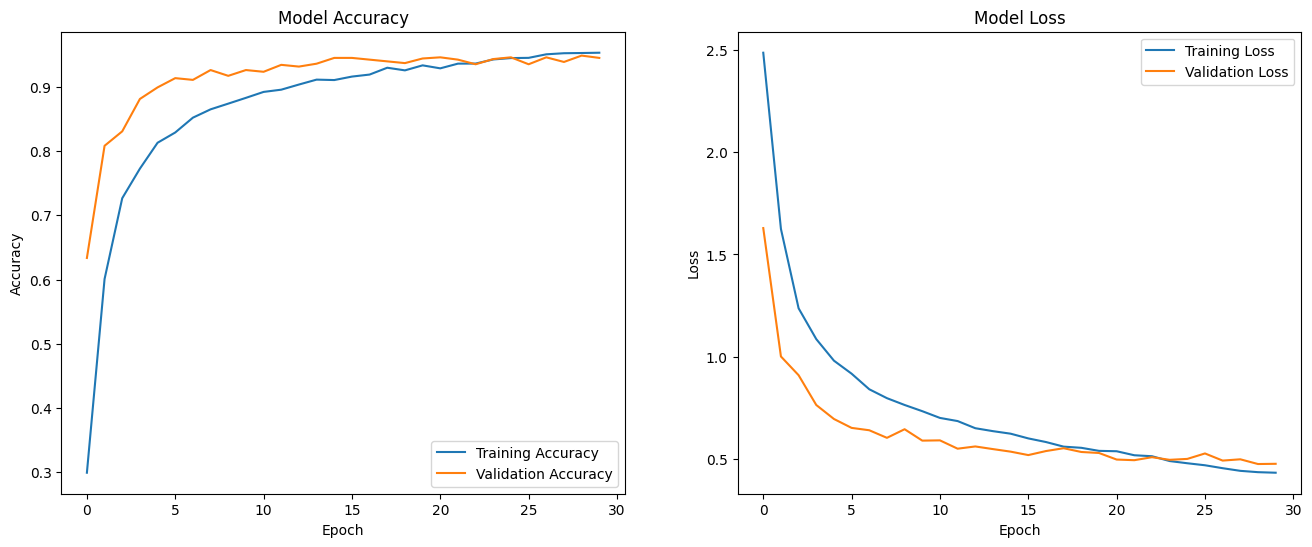

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_data = pd.read_csv('/content/training_log_activation_153_v9.csv')

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.title('Model Accuracy')
plt.plot(log_data['epoch'], log_data['accuracy'], label='Training Accuracy')
plt.plot(log_data['epoch'], log_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Model Loss')
plt.plot(log_data['epoch'], log_data['loss'], label='Training Loss')
plt.plot(log_data['epoch'], log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loaded_model.evaluate(test_set)

25/25 [==============================] - 11s 435ms/step - loss: 0.5088 - accuracy: 0.9447


[0.5088399052619934, 0.9447415471076965]

In [ ]:
# activation_153 test v9
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 2.4867 - accuracy: 0.2993

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 258s 1s/step - loss: 2.4867 - accuracy: 0.2993 - val_loss: 1.6289 - val_accuracy: 0.6337
Epoch 2/20
198/198 [==============================] - 250s 1s/step - loss: 1.6248 - accuracy: 0.6009 - val_loss: 1.0009 - val_accuracy: 0.8083
Epoch 3/20
198/198 [==============================] - 249s 1s/step - loss: 1.2365 - accuracy: 0.7267 - val_loss: 0.9092 - val_accuracy: 0.8308
Epoch 4/20
198/198 [==============================] - 250s 1s/step - loss: 1.0858 - accuracy: 0.7727 - val_loss: 0.7635 - val_accuracy: 0.8812
Epoch 5/20
198/198 [==============================] - 253s 1s/step - loss: 0.9804 - accuracy: 0.8130 - val_loss: 0.6951 - val_accuracy: 0.8992
Epoch 6/20
198/198 [==============================] - 248s 1s/step - loss: 0.9166 - accuracy: 0.8290 - val_loss: 0.6515 - val_accuracy: 0.9136
Epoch 7/20
198/198 [==============================] - 254s 1s/step - loss: 0.8404 - accuracy: 0.8521 - val_loss: 0.6400 - val_accuracy: 0.9109
Epoch 8/20

In [ ]:
model.evaluate(test_set)

25/25 [==============================] - 7s 272ms/step - loss: 0.5598 - accuracy: 0.9287


[0.5597549676895142, 0.9286987781524658]

Text(0.5, 1.0, 'Model Loss')

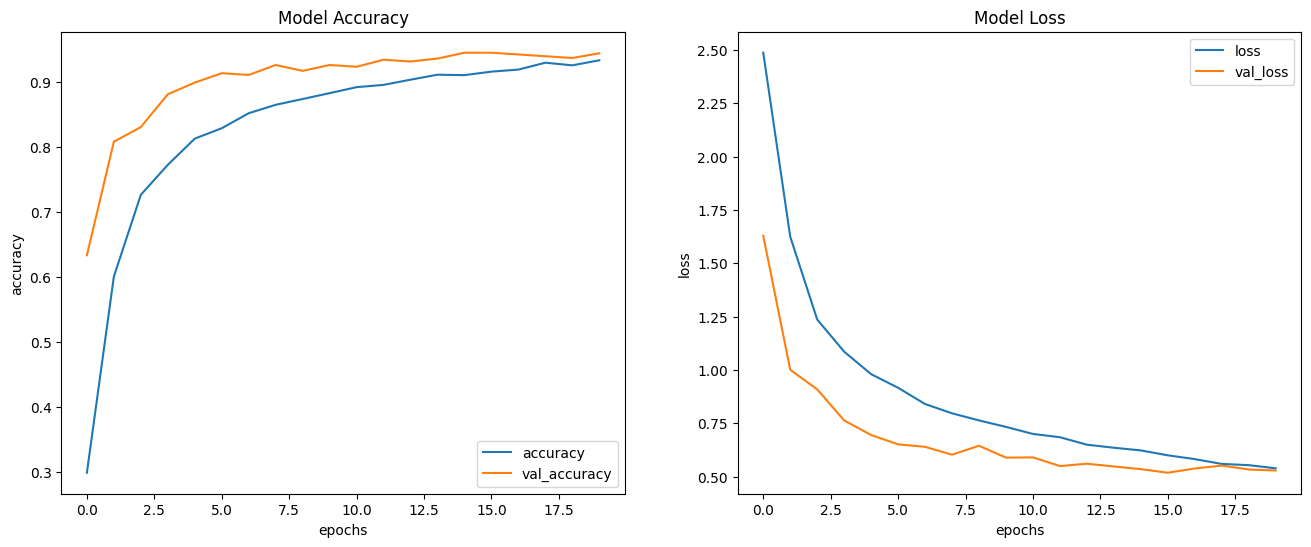

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.title('Model Loss')

### Prev Train

In [ ]:
# activation_153 test v4 (21)
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model_activation_153_v4.h5')

loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(0.000005),
                    metrics = ['accuracy'])

new_history = loaded_model.fit(train_set,
                               callbacks = [csv_logger, stop_callback],
                               validation_data = val_set,
                               epochs = 10
                               )

Epoch 1/10
198/198 [==============================] - 370s 2s/step - loss: 0.4624 - accuracy: 0.9616 - val_loss: 0.6936 - val_accuracy: 0.8994
Epoch 2/10
198/198 [==============================] - 318s 2s/step - loss: 0.4549 - accuracy: 0.9630 - val_loss: 0.6915 - val_accuracy: 0.8980
Epoch 3/10
198/198 [==============================] - 318s 2s/step - loss: 0.4564 - accuracy: 0.9637 - val_loss: 0.7164 - val_accuracy: 0.8949
Epoch 4/10
198/198 [==============================] - 317s 2s/step - loss: 0.4544 - accuracy: 0.9633 - val_loss: 0.7174 - val_accuracy: 0.8953
Epoch 5/10
198/198 [==============================] - 316s 2s/step - loss: 0.4565 - accuracy: 0.9621 - val_loss: 0.7260 - val_accuracy: 0.8917
Epoch 6/10
198/198 [==============================] - 317s 2s/step - loss: 0.4384 - accuracy: 0.9690 - val_loss: 0.6928 - val_accuracy: 0.8985
Epoch 7/10
198/198 [==============================] - 317s 2s/step - loss: 0.4445 - accuracy: 0.9648 - val_loss: 0.7146 - val_accuracy: 0.8931

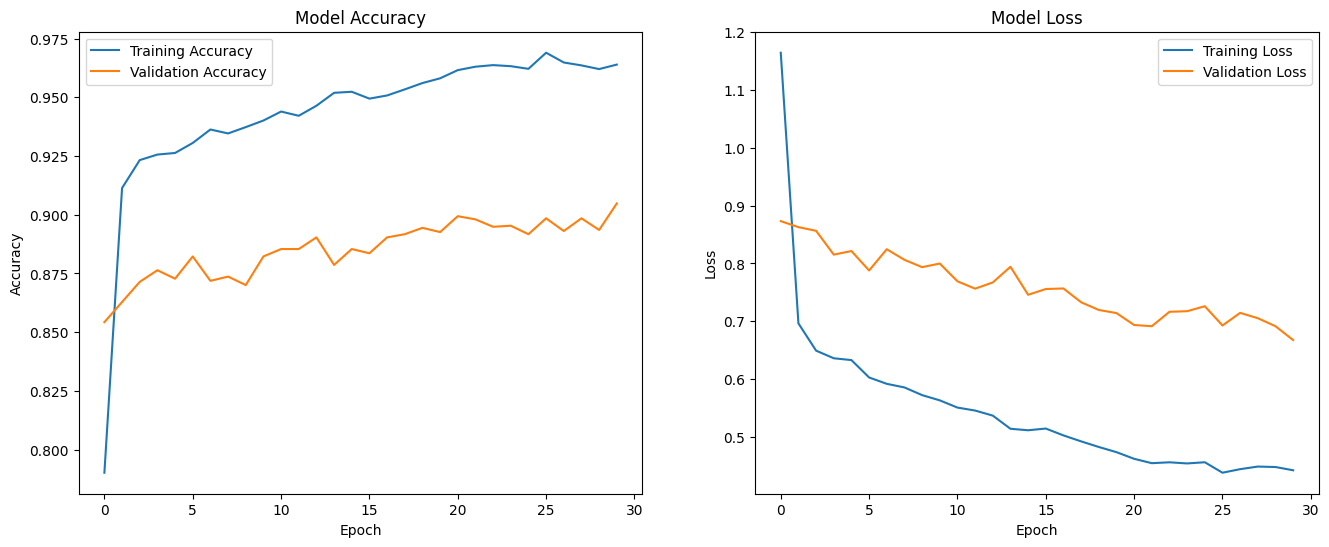

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_data = pd.read_csv('/content/training_log_activation_153_v4(2).csv')

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.title('Model Accuracy')
plt.plot(log_data['epoch'], log_data['accuracy'], label='Training Accuracy')
plt.plot(log_data['epoch'], log_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Model Loss')
plt.plot(log_data['epoch'], log_data['loss'], label='Training Loss')
plt.plot(log_data['epoch'], log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# activation_153 test v8
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 1.6656 - accuracy: 0.5892

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 311s 2s/step - loss: 1.6656 - accuracy: 0.5892 - val_loss: 1.3911 - val_accuracy: 0.6751
Epoch 2/20
198/198 [==============================] - 306s 2s/step - loss: 1.2237 - accuracy: 0.7306 - val_loss: 1.1198 - val_accuracy: 0.7622
Epoch 3/20
198/198 [==============================] - 301s 2s/step - loss: 1.0159 - accuracy: 0.8009 - val_loss: 1.0453 - val_accuracy: 0.7852
Epoch 4/20
198/198 [==============================] - 298s 2s/step - loss: 0.9129 - accuracy: 0.8312 - val_loss: 0.9862 - val_accuracy: 0.8199
Epoch 5/20
198/198 [==============================] - 295s 1s/step - loss: 0.8399 - accuracy: 0.8538 - val_loss: 0.9399 - val_accuracy: 0.8272
Epoch 6/20
198/198 [==============================] - 295s 1s/step - loss: 0.7849 - accuracy: 0.8690 - val_loss: 0.8850 - val_accuracy: 0.8299
Epoch 7/20
198/198 [==============================] - 295s 1s/step - loss: 0.7414 - accuracy: 0.8869 - val_loss: 0.8019 - val_accuracy: 0.8628
Epoch 8/20

In [ ]:
# activation_153 test v7 (36 dst)
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model_activation_153_v7.h5')

loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(0.00002),
                    metrics = ['accuracy'])

new_history = loaded_model.fit(train_set,
                               callbacks = [csv_logger, stop_callback],
                               validation_data = val_set,
                               epochs = 15
                               )

Epoch 1/15
198/198 [==============================] - 323s 2s/step - loss: 0.4896 - accuracy: 0.9471 - val_loss: 0.7145 - val_accuracy: 0.8786
Epoch 2/15
198/198 [==============================] - 320s 2s/step - loss: 0.4731 - accuracy: 0.9494 - val_loss: 0.7079 - val_accuracy: 0.8917
Epoch 3/15
198/198 [==============================] - 311s 2s/step - loss: 0.4682 - accuracy: 0.9503 - val_loss: 0.7224 - val_accuracy: 0.8813
Epoch 4/15
198/198 [==============================] - 314s 2s/step - loss: 0.4737 - accuracy: 0.9483 - val_loss: 0.6847 - val_accuracy: 0.8899
Epoch 5/15
198/198 [==============================] - 311s 2s/step - loss: 0.4604 - accuracy: 0.9522 - val_loss: 0.7147 - val_accuracy: 0.8818
Epoch 6/15
 74/198 [==========>...................] - ETA: 2:42 - loss: 0.4533 - accuracy: 0.9550

In [ ]:
# activation_153 test v7 (21 dst)
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model_activation_153_v7.h5')

loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(0.00003),
                    metrics = ['accuracy'])

new_history = loaded_model.fit(train_set,
                               callbacks = [csv_logger, stop_callback],
                               validation_data = val_set,
                               epochs = 15
                               )

Epoch 1/15
198/198 [==============================] - 344s 2s/step - loss: 0.6859 - accuracy: 0.8964 - val_loss: 0.8175 - val_accuracy: 0.8615
Epoch 2/15
198/198 [==============================] - 321s 2s/step - loss: 0.6687 - accuracy: 0.8997 - val_loss: 0.8041 - val_accuracy: 0.8574
Epoch 3/15
198/198 [==============================] - 316s 2s/step - loss: 0.6452 - accuracy: 0.9065 - val_loss: 0.7930 - val_accuracy: 0.8619
Epoch 4/15
198/198 [==============================] - 315s 2s/step - loss: 0.6324 - accuracy: 0.9140 - val_loss: 0.8093 - val_accuracy: 0.8547
Epoch 5/15
198/198 [==============================] - 335s 2s/step - loss: 0.6109 - accuracy: 0.9161 - val_loss: 0.8012 - val_accuracy: 0.8651
Epoch 6/15
198/198 [==============================] - 320s 2s/step - loss: 0.5959 - accuracy: 0.9192 - val_loss: 0.7719 - val_accuracy: 0.8651
Epoch 7/15
198/198 [==============================] - 318s 2s/step - loss: 0.5929 - accuracy: 0.9194 - val_loss: 0.7811 - val_accuracy: 0.8660

In [ ]:
# activation_153 test v7
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 2.8303 - accuracy: 0.1606

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 340s 2s/step - loss: 2.8303 - accuracy: 0.1606 - val_loss: 2.6565 - val_accuracy: 0.2947
Epoch 2/20
198/198 [==============================] - 315s 2s/step - loss: 2.4021 - accuracy: 0.3413 - val_loss: 2.0392 - val_accuracy: 0.5005
Epoch 3/20
198/198 [==============================] - 315s 2s/step - loss: 1.8442 - accuracy: 0.5315 - val_loss: 1.6093 - val_accuracy: 0.6187
Epoch 4/20
198/198 [==============================] - 313s 2s/step - loss: 1.4888 - accuracy: 0.6466 - val_loss: 1.4067 - val_accuracy: 0.6810
Epoch 5/20
198/198 [==============================] - 309s 2s/step - loss: 1.2886 - accuracy: 0.7078 - val_loss: 1.2669 - val_accuracy: 0.7157
Epoch 6/20
198/198 [==============================] - 311s 2s/step - loss: 1.1828 - accuracy: 0.7442 - val_loss: 1.1699 - val_accuracy: 0.7527
Epoch 7/20
198/198 [==============================] - 325s 2s/step - loss: 1.1054 - accuracy: 0.7691 - val_loss: 1.1266 - val_accuracy: 0.7635
Epoch 8/20

In [ ]:
# activation_153 test v7
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - 337s 2s/step - loss: 1.4820 - accuracy: 0.7107 - val_loss: 1.1100 - val_accuracy: 0.8114
Epoch 2/20
198/198 [==============================] - 298s 2s/step - loss: 0.9840 - accuracy: 0.8349 - val_loss: 0.9675 - val_accuracy: 0.8330
Epoch 3/20
198/198 [==============================] - 291s 1s/step - loss: 0.8441 - accuracy: 0.8662 - val_loss: 0.9136 - val_accuracy: 0.8475
Epoch 4/20
198/198 [==============================] - 291s 1s/step - loss: 0.7808 - accuracy: 0.8844 - val_loss: 0.8894 - val_accuracy: 0.8452
Epoch 5/20
198/198 [==============================] - 293s 1s/step - loss: 0.7465 - accuracy: 0.8944 - val_loss: 0.8626 - val_accuracy: 0.8556
Epoch 6/20
198/198 [==============================] - 289s 1s/step - loss: 0.7255 - accuracy: 0.8961 - val_loss: 0.8615 - val_accuracy: 0.8610
Epoch 7/20
198/198 [==============================] - 292s 1s/step - loss: 0.7031 - accuracy: 0.9049 - val_loss: 0.8293 - val_accuracy: 0.8655

In [ ]:
# activation_153 test v6
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - 325s 2s/step - loss: 2.4310 - accuracy: 0.3345 - val_loss: 1.8186 - val_accuracy: 0.5997
Epoch 2/20
198/198 [==============================] - 306s 2s/step - loss: 1.5607 - accuracy: 0.6340 - val_loss: 1.3724 - val_accuracy: 0.7238
Epoch 3/20
198/198 [==============================] - 307s 2s/step - loss: 1.2386 - accuracy: 0.7396 - val_loss: 1.2202 - val_accuracy: 0.7495
Epoch 4/20
198/198 [==============================] - 310s 2s/step - loss: 1.1276 - accuracy: 0.7720 - val_loss: 1.1305 - val_accuracy: 0.7838
Epoch 5/20
198/198 [==============================] - 304s 2s/step - loss: 1.0782 - accuracy: 0.7919 - val_loss: 1.1174 - val_accuracy: 0.7902
Epoch 6/20
198/198 [==============================] - 328s 2s/step - loss: 1.0002 - accuracy: 0.8166 - val_loss: 1.0975 - val_accuracy: 0.7847
Epoch 7/20
198/198 [==============================] - 307s 2s/step - loss: 0.9672 - accuracy: 0.8310 - val_loss: 1.0069 - val_accuracy: 0.8163

In [ ]:
# activation_153 test v5
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 30)

Epoch 1/30
198/198 [==============================] - 358s 2s/step - loss: 1.7042 - accuracy: 0.5838 - val_loss: 1.5503 - val_accuracy: 0.6291
Epoch 2/30
198/198 [==============================] - 336s 2s/step - loss: 1.4175 - accuracy: 0.6708 - val_loss: 1.3582 - val_accuracy: 0.6877
Epoch 3/30
198/198 [==============================] - 345s 2s/step - loss: 1.2449 - accuracy: 0.7236 - val_loss: 1.2644 - val_accuracy: 0.7342
Epoch 4/30
198/198 [==============================] - 310s 2s/step - loss: 1.1457 - accuracy: 0.7529 - val_loss: 1.1544 - val_accuracy: 0.7577
Epoch 5/30
198/198 [==============================] - 318s 2s/step - loss: 1.0885 - accuracy: 0.7761 - val_loss: 1.1369 - val_accuracy: 0.7608
Epoch 6/30
198/198 [==============================] - 315s 2s/step - loss: 1.0095 - accuracy: 0.8011 - val_loss: 1.0844 - val_accuracy: 0.7766
Epoch 7/30
198/198 [==============================] - 310s 2s/step - loss: 0.9483 - accuracy: 0.8187 - val_loss: 1.0511 - val_accuracy: 0.7920

In [ ]:
# activation_153 test v4
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - 333s 2s/step - loss: 1.1640 - accuracy: 0.7901 - val_loss: 0.8730 - val_accuracy: 0.8542
Epoch 2/20
198/198 [==============================] - 341s 2s/step - loss: 0.6964 - accuracy: 0.9113 - val_loss: 0.8627 - val_accuracy: 0.8628
Epoch 3/20
198/198 [==============================] - 322s 2s/step - loss: 0.6493 - accuracy: 0.9233 - val_loss: 0.8563 - val_accuracy: 0.8714
Epoch 4/20
198/198 [==============================] - 341s 2s/step - loss: 0.6361 - accuracy: 0.9256 - val_loss: 0.8152 - val_accuracy: 0.8764
Epoch 5/20
198/198 [==============================] - 321s 2s/step - loss: 0.6330 - accuracy: 0.9263 - val_loss: 0.8214 - val_accuracy: 0.8727
Epoch 6/20
198/198 [==============================] - 316s 2s/step - loss: 0.6029 - accuracy: 0.9306 - val_loss: 0.7877 - val_accuracy: 0.8822
Epoch 7/20
198/198 [==============================] - 318s 2s/step - loss: 0.5919 - accuracy: 0.9363 - val_loss: 0.8245 - val_accuracy: 0.8718

Text(0.5, 1.0, 'Model Loss')

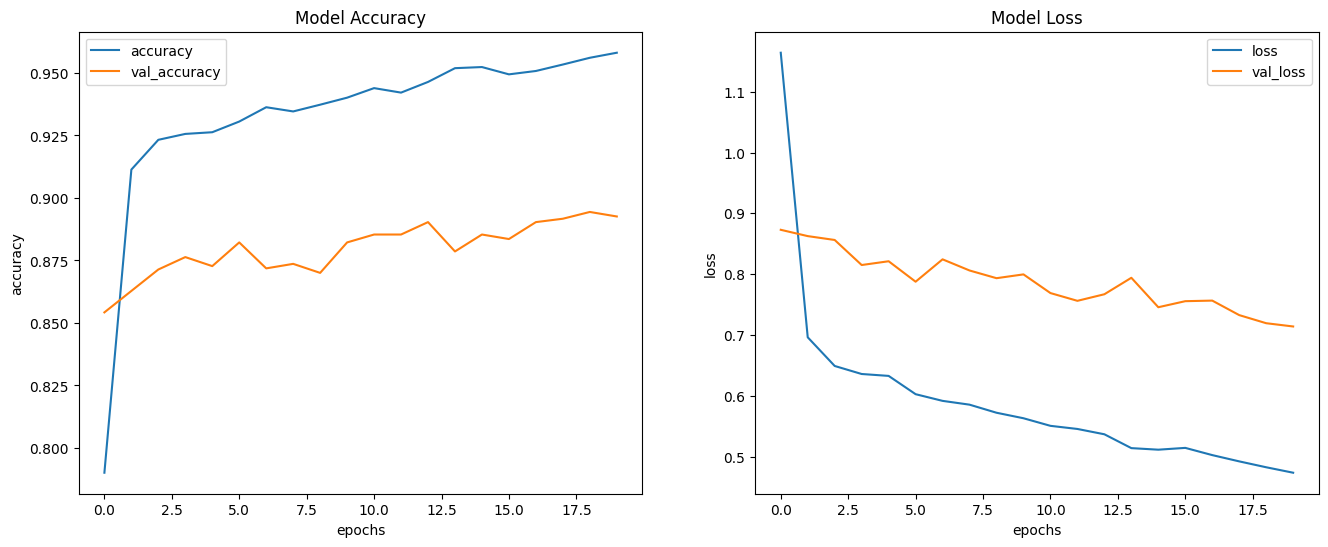

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.title('Model Loss')

In [ ]:
# activation_153 test v3 (epoch 19 dst)
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/Copy of model_checkpoint_activation_153_v3 (epoch 18).h5')
new_history = loaded_model.fit(train_set,
                               callbacks = [csv_logger],
                               validation_data = val_set,
                               epochs = 7
                               )

Epoch 1/7
198/198 [==============================] - 315s 2s/step - loss: 0.4585 - accuracy: 0.8989 - val_loss: 0.5244 - val_accuracy: 0.8863
Epoch 2/7
198/198 [==============================] - 310s 2s/step - loss: 0.4388 - accuracy: 0.9070 - val_loss: 0.5830 - val_accuracy: 0.8727
Epoch 3/7
198/198 [==============================] - 312s 2s/step - loss: 0.4320 - accuracy: 0.9053 - val_loss: 0.5649 - val_accuracy: 0.8827
Epoch 4/7
198/198 [==============================] - 315s 2s/step - loss: 0.4320 - accuracy: 0.9061 - val_loss: 0.5493 - val_accuracy: 0.8831
Epoch 5/7
198/198 [==============================] - 313s 2s/step - loss: 0.4102 - accuracy: 0.9113 - val_loss: 0.5543 - val_accuracy: 0.8768
Epoch 6/7
198/198 [==============================] - 305s 2s/step - loss: 0.4217 - accuracy: 0.9075 - val_loss: 0.5663 - val_accuracy: 0.8764
Epoch 7/7
198/198 [==============================] - 298s 2s/step - loss: 0.3958 - accuracy: 0.9134 - val_loss: 0.5161 - val_accuracy: 0.8863


In [ ]:
# activation_153 test v3
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 2.1227 - accuracy: 0.3233

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 353s 2s/step - loss: 2.1227 - accuracy: 0.3233 - val_loss: 1.6440 - val_accuracy: 0.5343
Epoch 2/20
198/198 [==============================] - 309s 2s/step - loss: 1.4944 - accuracy: 0.5551 - val_loss: 1.2438 - val_accuracy: 0.6864
Epoch 3/20
198/198 [==============================] - 307s 2s/step - loss: 1.2384 - accuracy: 0.6470 - val_loss: 1.0300 - val_accuracy: 0.7432
Epoch 4/20
198/198 [==============================] - 308s 2s/step - loss: 1.0812 - accuracy: 0.7038 - val_loss: 0.8988 - val_accuracy: 0.7703
Epoch 5/20
198/198 [==============================] - 309s 2s/step - loss: 0.9626 - accuracy: 0.7446 - val_loss: 0.8828 - val_accuracy: 0.7789
Epoch 6/20
198/198 [==============================] - 309s 2s/step - loss: 0.8704 - accuracy: 0.7742 - val_loss: 0.7634 - val_accuracy: 0.8222
Epoch 7/20
198/198 [==============================] - 310s 2s/step - loss: 0.8226 - accuracy: 0.7892 - val_loss: 0.7882 - val_accuracy: 0.8105
Epoch 8/20

Text(0.5, 1.0, 'Model Loss')

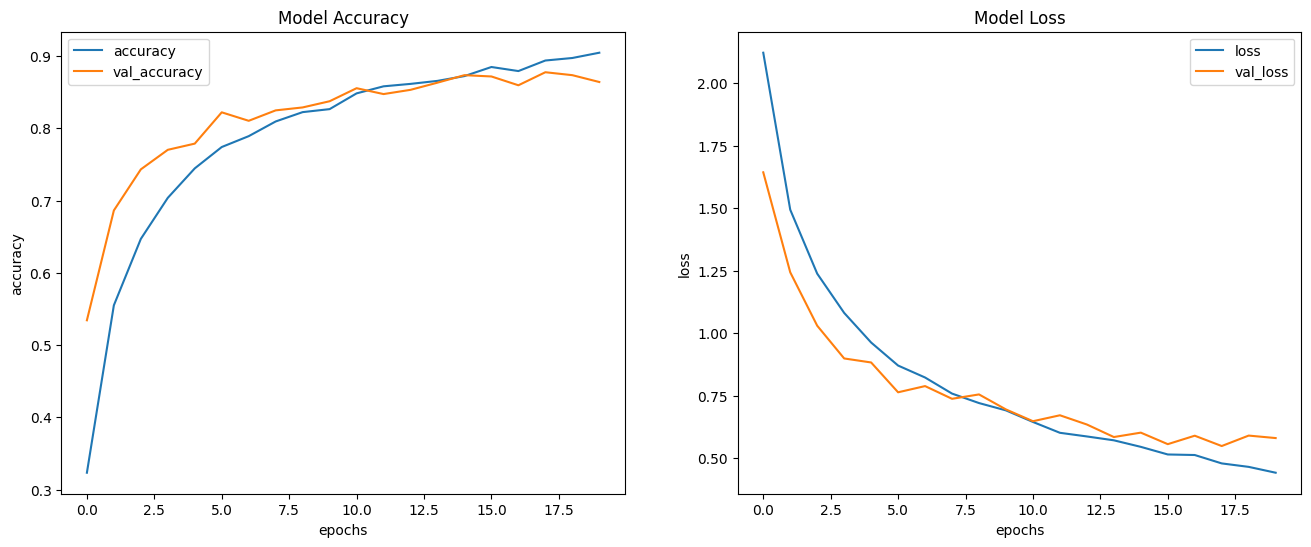

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.title('Model Loss')

In [ ]:
# activation_153 test v2
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 2.3215 - accuracy: 0.2496

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 351s 2s/step - loss: 2.3215 - accuracy: 0.2496 - val_loss: 2.0448 - val_accuracy: 0.3940
Epoch 2/20
198/198 [==============================] - 332s 2s/step - loss: 1.9329 - accuracy: 0.3853 - val_loss: 1.7219 - val_accuracy: 0.4756
Epoch 3/20
198/198 [==============================] - 329s 2s/step - loss: 1.7040 - accuracy: 0.4710 - val_loss: 1.4892 - val_accuracy: 0.5763
Epoch 4/20
198/198 [==============================] - 329s 2s/step - loss: 1.5343 - accuracy: 0.5352 - val_loss: 1.3822 - val_accuracy: 0.6083
Epoch 5/20
198/198 [==============================] - 344s 2s/step - loss: 1.4126 - accuracy: 0.5742 - val_loss: 1.2628 - val_accuracy: 0.6570
Epoch 6/20
198/198 [==============================] - 345s 2s/step - loss: 1.3077 - accuracy: 0.6193 - val_loss: 1.1950 - val_accuracy: 0.6742
Epoch 7/20
198/198 [==============================] - 345s 2s/step - loss: 1.2139 - accuracy: 0.6499 - val_loss: 1.1114 - val_accuracy: 0.7189
Epoch 8/20

In [ ]:
# activation_153 test v1
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - 344s 2s/step - loss: 1.3363 - accuracy: 0.6344 - val_loss: 0.7263 - val_accuracy: 0.8461
Epoch 2/20
198/198 [==============================] - 315s 2s/step - loss: 0.6780 - accuracy: 0.8409 - val_loss: 0.6326 - val_accuracy: 0.8723
Epoch 3/20
198/198 [==============================] - 313s 2s/step - loss: 0.6022 - accuracy: 0.8625 - val_loss: 0.5880 - val_accuracy: 0.8827
Epoch 4/20
 64/198 [========>.....................] - ETA: 2:47 - loss: 0.5757 - accuracy: 0.8728

In [ ]:
# activation_163 test v1
# model_checkpoint_activation_163 sampe epoch 11
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - 367s 2s/step - loss: 1.1077 - accuracy: 0.6704 - val_loss: 0.6916 - val_accuracy: 0.7906
Epoch 2/20
198/198 [==============================] - 348s 2s/step - loss: 0.3860 - accuracy: 0.8882 - val_loss: 0.4747 - val_accuracy: 0.8610
Epoch 3/20
198/198 [==============================] - 335s 2s/step - loss: 0.2682 - accuracy: 0.9272 - val_loss: 0.4410 - val_accuracy: 0.8709
Epoch 4/20
198/198 [==============================] - 333s 2s/step - loss: 0.2012 - accuracy: 0.9442 - val_loss: 0.4131 - val_accuracy: 0.8836
Epoch 5/20
198/198 [==============================] - 324s 2s/step - loss: 0.1712 - accuracy: 0.9534 - val_loss: 0.4583 - val_accuracy: 0.8750
Epoch 6/20
198/198 [==============================] - 333s 2s/step - loss: 0.1317 - accuracy: 0.9657 - val_loss: 0.3843 - val_accuracy: 0.8949
Epoch 7/20
198/198 [==============================] - 327s 2s/step - loss: 0.1218 - accuracy: 0.9692 - val_loss: 0.3952 - val_accuracy: 0.8985

KeyboardInterrupt: ignored

In [ ]:
# conv2d_263 test v1
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 1.4751 - accuracy: 0.5143

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 366s 2s/step - loss: 1.4751 - accuracy: 0.5143 - val_loss: 1.0942 - val_accuracy: 0.6588
Epoch 2/20
198/198 [==============================] - 338s 2s/step - loss: 0.4955 - accuracy: 0.8448 - val_loss: 0.5213 - val_accuracy: 0.8412
Epoch 3/20
198/198 [==============================] - 332s 2s/step - loss: 0.3098 - accuracy: 0.9090 - val_loss: 0.4301 - val_accuracy: 0.8696
Epoch 4/20
198/198 [==============================] - 325s 2s/step - loss: 0.2261 - accuracy: 0.9353 - val_loss: 0.4036 - val_accuracy: 0.8854
Epoch 5/20
198/198 [==============================] - 325s 2s/step - loss: 0.1808 - accuracy: 0.9494 - val_loss: 0.3834 - val_accuracy: 0.8949
Epoch 6/20
198/198 [==============================] - 317s 2s/step - loss: 0.1553 - accuracy: 0.9575 - val_loss: 0.4644 - val_accuracy: 0.8822
Epoch 7/20
198/198 [==============================] - 319s 2s/step - loss: 0.1315 - accuracy: 0.9664 - val_loss: 0.4673 - val_accuracy: 0.8827
Epoch 8/20

Text(0.5, 1.0, 'Model Loss')

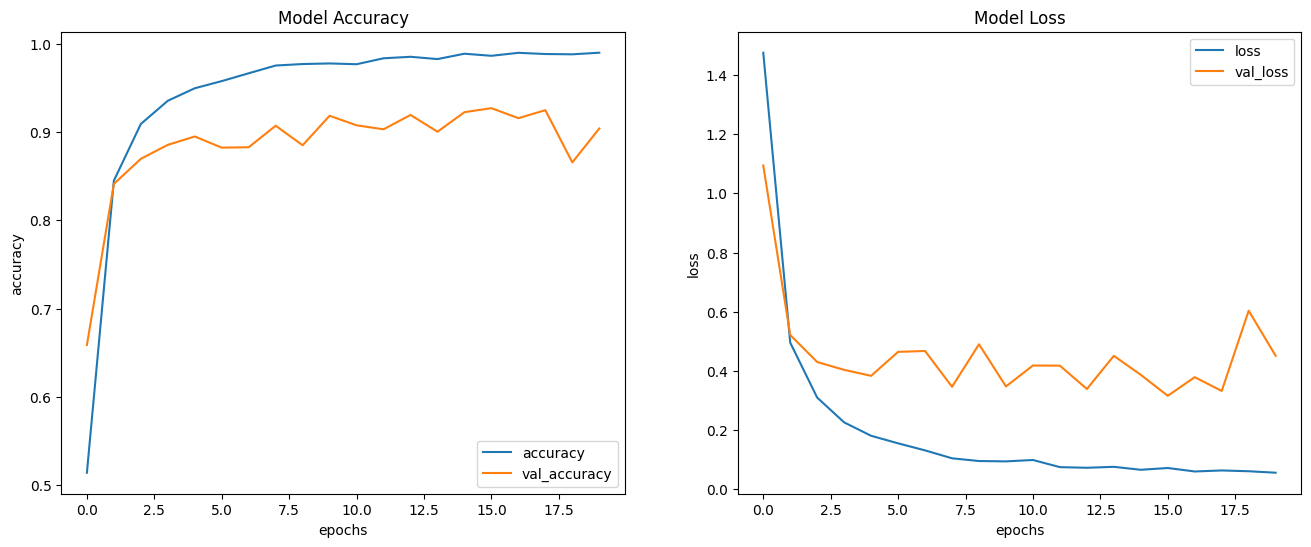

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.title('Model Loss')

In [ ]:
# conv2d 84 test v2
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model_checkpoint_2.h5')
new_history = loaded_model.fit(train_set,
                               validation_data = val_set,
                               epochs = 5,
                               callbacks = [csv_logger, checkpoint_callback, stop_callback])

Epoch 1/5
198/198 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8913

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 329s 2s/step - loss: 0.3724 - accuracy: 0.8913 - val_loss: 0.6170 - val_accuracy: 0.8335
Epoch 2/5
198/198 [==============================] - 309s 2s/step - loss: 0.3685 - accuracy: 0.8919 - val_loss: 0.5970 - val_accuracy: 0.8353
Epoch 3/5
198/198 [==============================] - 299s 2s/step - loss: 0.3469 - accuracy: 0.8991 - val_loss: 0.6420 - val_accuracy: 0.8254
Epoch 4/5
198/198 [==============================] - 302s 2s/step - loss: 0.3501 - accuracy: 0.9020 - val_loss: 0.6968 - val_accuracy: 0.8051
Epoch 5/5
198/198 [==============================] - 302s 2s/step - loss: 0.3534 - accuracy: 0.8967 - val_loss: 0.6002 - val_accuracy: 0.8394


In [ ]:
# conv2d 84 test v2
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model_checkpoint.h5')
new_history = loaded_model.fit(train_set,
                               validation_data = val_set,
                               epochs = 5,
                               callbacks = [csv_logger, checkpoint_callback, stop_callback])

Epoch 1/5
198/198 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 316s 2s/step - loss: 0.3724 - accuracy: 0.8863 - val_loss: 0.6421 - val_accuracy: 0.8326
Epoch 2/5
198/198 [==============================] - 323s 2s/step - loss: 0.3746 - accuracy: 0.8887 - val_loss: 0.6580 - val_accuracy: 0.8177
Epoch 3/5
198/198 [==============================] - 309s 2s/step - loss: 0.3790 - accuracy: 0.8874 - val_loss: 0.6786 - val_accuracy: 0.8087
Epoch 4/5
198/198 [==============================] - 315s 2s/step - loss: 0.3564 - accuracy: 0.8955 - val_loss: 0.6134 - val_accuracy: 0.8330
Epoch 5/5
198/198 [==============================] - 302s 2s/step - loss: 0.3728 - accuracy: 0.8920 - val_loss: 0.6753 - val_accuracy: 0.8032


Text(0.5, 1.0, 'Model Loss')

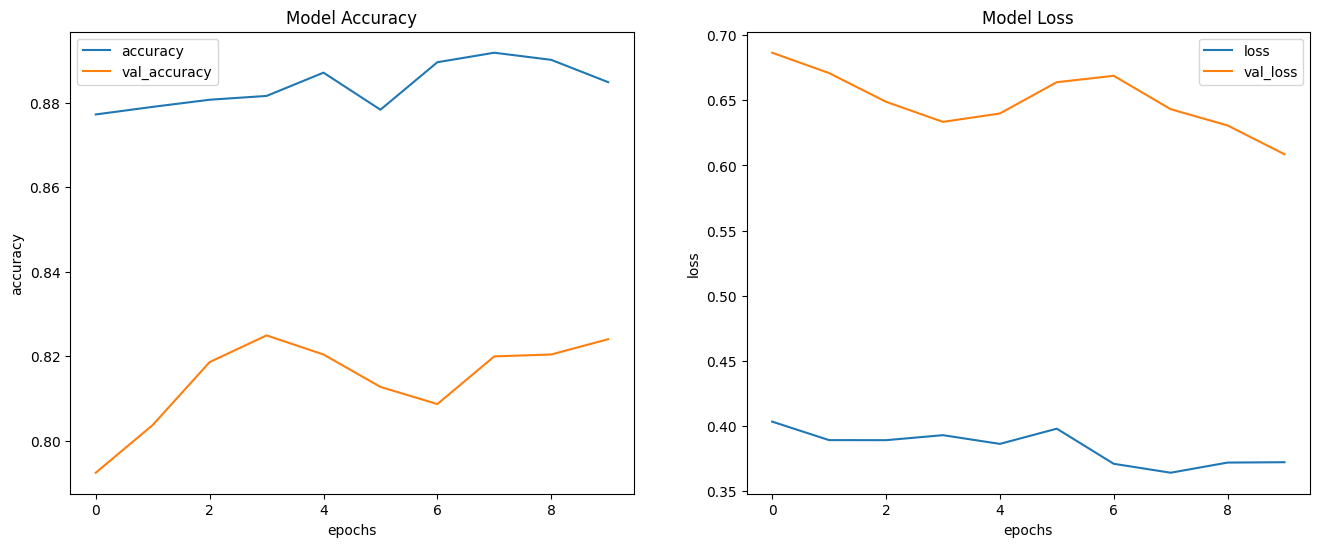

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(new_history, 'accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(new_history, 'loss')
plt.title('Model Loss')

In [ ]:
# conv2d 84 test v1
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
119/119 [==============================] - 333s 3s/step - loss: 1.0526 - accuracy: 0.6734 - val_loss: 0.8307 - val_accuracy: 0.7432
Epoch 2/20
119/119 [==============================] - 327s 3s/step - loss: 0.6128 - accuracy: 0.8099 - val_loss: 0.7337 - val_accuracy: 0.7726
Epoch 3/20
119/119 [==============================] - 325s 3s/step - loss: 0.5349 - accuracy: 0.8347 - val_loss: 0.6839 - val_accuracy: 0.8001
Epoch 4/20
119/119 [==============================] - 347s 3s/step - loss: 0.4977 - accuracy: 0.8410 - val_loss: 0.6962 - val_accuracy: 0.7897
Epoch 5/20
119/119 [==============================] - 327s 3s/step - loss: 0.4638 - accuracy: 0.8537 - val_loss: 0.7165 - val_accuracy: 0.7906
Epoch 6/20
119/119 [==============================] - 326s 3s/step - loss: 0.4589 - accuracy: 0.8603 - val_loss: 0.6927 - val_accuracy: 0.7924
Epoch 7/20
119/119 [==============================] - 322s 3s/step - loss: 0.4415 - accuracy: 0.8633 - val_loss: 0.6721 - val_accuracy: 0.7920

Text(0.5, 1.0, 'Model Loss')

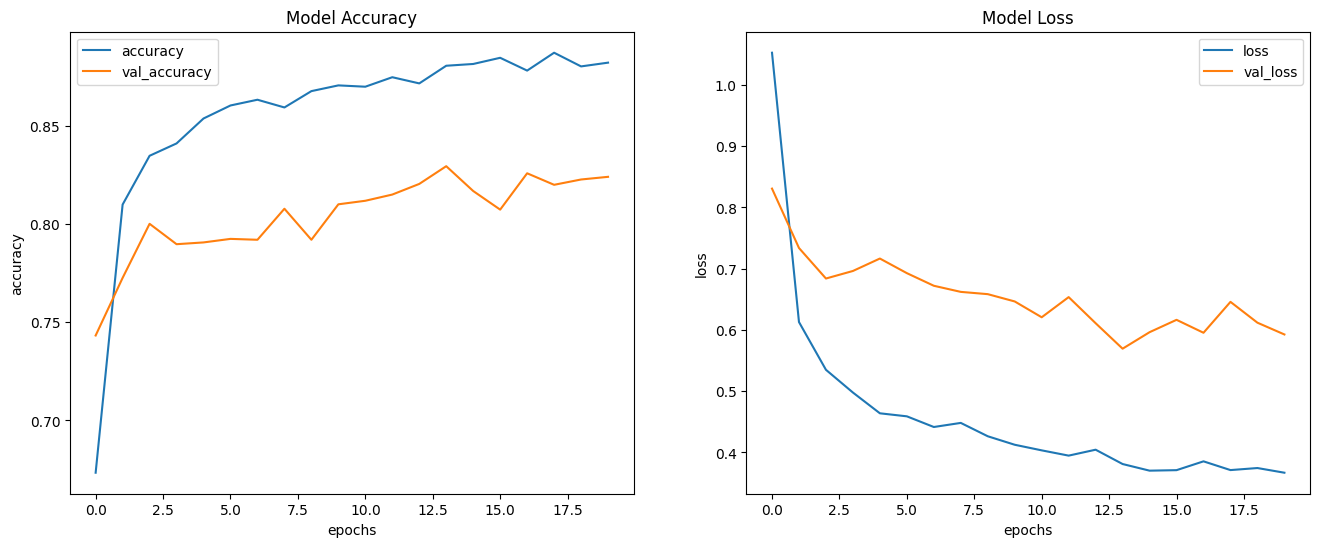

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.title('Model Loss')

In [ ]:
# conv2d 272 test v1
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
119/119 [==============================] - ETA: 0s - loss: 1.0258 - accuracy: 0.6797

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


119/119 [==============================] - 343s 3s/step - loss: 1.0258 - accuracy: 0.6797 - val_loss: 0.8128 - val_accuracy: 0.7554
Epoch 2/20
119/119 [==============================] - 346s 3s/step - loss: 0.6040 - accuracy: 0.8055 - val_loss: 0.6916 - val_accuracy: 0.7784
Epoch 3/20
119/119 [==============================] - 342s 3s/step - loss: 0.5305 - accuracy: 0.8330 - val_loss: 0.6741 - val_accuracy: 0.7983
Epoch 4/20
119/119 [==============================] - 327s 3s/step - loss: 0.4804 - accuracy: 0.8494 - val_loss: 0.6739 - val_accuracy: 0.7942
Epoch 5/20
 90/119 [=====================>........] - ETA: 1:04 - loss: 0.4605 - accuracy: 0.8538

In [ ]:
# conv2d 178 test v1
history = model.fit(train_set,
                    callbacks=[checkpoint_callback],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
119/119 [==============================] - 310s 3s/step - loss: 0.9507 - accuracy: 0.6957 - val_loss: 0.8188 - val_accuracy: 0.7450
Epoch 2/20
119/119 [==============================] - 301s 3s/step - loss: 0.5596 - accuracy: 0.8155 - val_loss: 0.7291 - val_accuracy: 0.7685
Epoch 3/20
119/119 [==============================] - 327s 3s/step - loss: 0.5113 - accuracy: 0.8329 - val_loss: 0.6558 - val_accuracy: 0.7897
Epoch 4/20
119/119 [==============================] - 323s 3s/step - loss: 0.4744 - accuracy: 0.8389 - val_loss: 0.7056 - val_accuracy: 0.7825
Epoch 5/20
119/119 [==============================] - 302s 3s/step - loss: 0.4334 - accuracy: 0.8560 - val_loss: 0.6447 - val_accuracy: 0.8051
Epoch 6/20
119/119 [==============================] - 288s 2s/step - loss: 0.4131 - accuracy: 0.8643 - val_loss: 0.6164 - val_accuracy: 0.8073
Epoch 7/20
119/119 [==============================] - 288s 2s/step - loss: 0.4060 - accuracy: 0.8642 - val_loss: 0.7250 - val_accuracy: 0.7884

Text(0.5, 1.0, 'Model Loss')

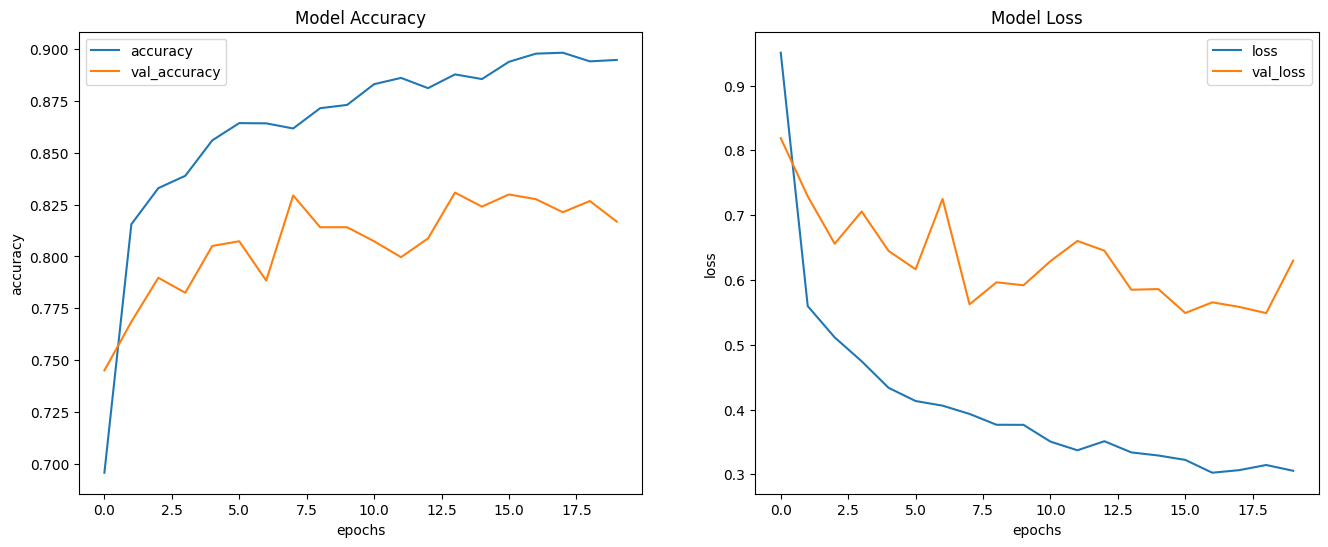

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.title('Model Loss')

In [ ]:
# mixed9 test v1
history = model.fit(train_set,
                    # callbacks=[checkpoint_callback],
                    validation_data=val_set,
                    epochs = 1)

119/119 [==============================] - 303s 3s/step - loss: 0.4222 - accuracy: 0.8633 - val_loss: 0.5890 - val_accuracy: 0.8227


In [ ]:
history = model.fit(train_set,
                    callbacks=[checkpoint_callback],
                    validation_data=val_set,
                    epochs = 10)

Epoch 1/10
119/119 [==============================] - 304s 3s/step - loss: 0.3798 - accuracy: 0.8776 - val_loss: 0.4985 - val_accuracy: 0.8556
Epoch 2/10
119/119 [==============================] - 303s 3s/step - loss: 0.3401 - accuracy: 0.8894 - val_loss: 0.4816 - val_accuracy: 0.8606
Epoch 3/10
 11/119 [=>............................] - ETA: 3:27 - loss: 0.3687 - accuracy: 0.8800

KeyboardInterrupt: ignored

In [ ]:
history = model.fit(train_set,
                    callbacks=[checkpoint_callback],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
279/279 [==============================] - ETA: 0s - loss: 0.8205 - accuracy: 0.7554

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


279/279 [==============================] - 333s 1s/step - loss: 0.8205 - accuracy: 0.7554 - val_loss: 0.6299 - val_accuracy: 0.8010
Epoch 2/20
279/279 [==============================] - 302s 1s/step - loss: 0.4665 - accuracy: 0.8542 - val_loss: 0.6028 - val_accuracy: 0.8186
Epoch 3/20
279/279 [==============================] - 329s 1s/step - loss: 0.3670 - accuracy: 0.8784 - val_loss: 0.6150 - val_accuracy: 0.8272
Epoch 4/20
279/279 [==============================] - 321s 1s/step - loss: 0.3227 - accuracy: 0.8979 - val_loss: 0.6257 - val_accuracy: 0.8195
Epoch 5/20
279/279 [==============================] - 311s 1s/step - loss: 0.2858 - accuracy: 0.9048 - val_loss: 0.5946 - val_accuracy: 0.8407
Epoch 6/20
279/279 [==============================] - 309s 1s/step - loss: 0.2493 - accuracy: 0.9199 - val_loss: 0.6582 - val_accuracy: 0.8168
Epoch 7/20
279/279 [==============================] - 316s 1s/step - loss: 0.2496 - accuracy: 0.9165 - val_loss: 0.5761 - val_accuracy: 0.8434
Epoch 8/20

In [ ]:
history = model.fit(train_set,
                    # callbacks=[checkpoint_callback],
                    validation_data=val_set,
                    epochs = 20)

Epoch 1/20
279/279 [==============================] - 3172s 11s/step - loss: 1.0625 - accuracy: 0.7498 - val_loss: 1.2857 - val_accuracy: 0.7690
Epoch 2/20
279/279 [==============================] - 3100s 11s/step - loss: 0.8145 - accuracy: 0.8380 - val_loss: 1.2122 - val_accuracy: 0.8136
Epoch 3/20
279/279 [==============================] - 3123s 11s/step - loss: 0.6968 - accuracy: 0.8643 - val_loss: 1.3806 - val_accuracy: 0.8032
Epoch 4/20
279/279 [==============================] - 3004s 11s/step - loss: 0.6619 - accuracy: 0.8812 - val_loss: 1.8340 - val_accuracy: 0.7748
Epoch 5/20
 15/279 [>.............................] - ETA: 37:36 - loss: 0.7360 - accuracy: 0.8625

In [ ]:
model.fit(train_set,
          # callbacks=[checkpoint_callback],
          validation_data=val_set,
          epochs = 20)

Epoch 1/20
87/87 [==============================] - 2649s 30s/step - loss: 2.1844 - accuracy: 0.6565 - val_loss: 1.2932 - val_accuracy: 0.7424
Epoch 2/20
87/87 [==============================] - 2546s 29s/step - loss: 0.8103 - accuracy: 0.8174 - val_loss: 1.3445 - val_accuracy: 0.7405
Epoch 3/20
15/87 [====>.........................] - ETA: 27:32 - loss: 0.7921 - accuracy: 0.8207

KeyboardInterrupt: ignored

In [ ]:
model.fit(train_set,
          # callbacks=[checkpoint_callback],
          validation_data=val_set,
          epochs = 10)

Epoch 1/10
88/88 [==============================] - 181s 1s/step - loss: 15.1929 - accuracy: 0.2934 - val_loss: 2.7081 - val_accuracy: 0.4375
Epoch 2/10
88/88 [==============================] - 117s 1s/step - loss: 3.6618 - accuracy: 0.4846 - val_loss: 2.7765 - val_accuracy: 0.4085
Epoch 3/10
88/88 [==============================] - 117s 1s/step - loss: 1.9848 - accuracy: 0.5887 - val_loss: 1.8710 - val_accuracy: 0.5312
Epoch 4/10
88/88 [==============================] - 122s 1s/step - loss: 1.6499 - accuracy: 0.6087 - val_loss: 1.1743 - val_accuracy: 0.7277
Epoch 5/10
88/88 [==============================] - 118s 1s/step - loss: 1.2139 - accuracy: 0.6926 - val_loss: 0.6147 - val_accuracy: 0.8058
Epoch 6/10
88/88 [==============================] - 118s 1s/step - loss: 1.0515 - accuracy: 0.7185 - val_loss: 0.9217 - val_accuracy: 0.7143
Epoch 7/10
88/88 [==============================] - 117s 1s/step - loss: 0.9525 - accuracy: 0.7322 - val_loss: 1.5801 - val_accuracy: 0.6027
Epoch 8/10
8

In [ ]:
model.fit(train_set,
          # callbacks=[checkpoint_callback],
          validation_data=val_set,
          epochs = 20)

Epoch 1/20
88/88 [==============================] - 145s 1s/step - loss: 1.7609 - accuracy: 0.4560 - val_loss: 1.4525 - val_accuracy: 0.5000
Epoch 2/20
88/88 [==============================] - 121s 1s/step - loss: 1.0532 - accuracy: 0.6577 - val_loss: 1.2725 - val_accuracy: 0.5647
Epoch 3/20
88/88 [==============================] - 123s 1s/step - loss: 0.8836 - accuracy: 0.7015 - val_loss: 0.6420 - val_accuracy: 0.8103
Epoch 4/20
88/88 [==============================] - 122s 1s/step - loss: 0.8237 - accuracy: 0.7302 - val_loss: 1.5760 - val_accuracy: 0.5112
Epoch 5/20
88/88 [==============================] - 128s 1s/step - loss: 0.7816 - accuracy: 0.7432 - val_loss: 0.9688 - val_accuracy: 0.6629
Epoch 6/20
 5/88 [>.............................] - ETA: 1:40 - loss: 0.7334 - accuracy: 0.7520

KeyboardInterrupt: ignored

In [ ]:
model.fit(train_set,
          # callbacks=[checkpoint_callback],
          validation_data=val_set,
          epochs = 20)

Epoch 1/20
82/82 [==============================] - 83s 887ms/step - loss: 2.4290 - accuracy: 0.1679 - val_loss: 1.9768 - val_accuracy: 0.3572
Epoch 2/20
82/82 [==============================] - 70s 852ms/step - loss: 2.0372 - accuracy: 0.3009 - val_loss: 1.5423 - val_accuracy: 0.5036
Epoch 3/20
82/82 [==============================] - 72s 883ms/step - loss: 1.8208 - accuracy: 0.3731 - val_loss: 1.3623 - val_accuracy: 0.5495
Epoch 4/20
82/82 [==============================] - 70s 848ms/step - loss: 1.7019 - accuracy: 0.4178 - val_loss: 1.1322 - val_accuracy: 0.6844
Epoch 5/20
82/82 [==============================] - 70s 852ms/step - loss: 1.5999 - accuracy: 0.4610 - val_loss: 0.9344 - val_accuracy: 0.7475
Epoch 6/20
82/82 [==============================] - 70s 844ms/step - loss: 1.4985 - accuracy: 0.5000 - val_loss: 0.9410 - val_accuracy: 0.7446
Epoch 7/20
82/82 [==============================] - 72s 877ms/step - loss: 1.4351 - accuracy: 0.5233 - val_loss: 0.8609 - val_accuracy: 0.7532

In [ ]:
model.fit(train_set,
          # callbacks=[checkpoint_callback],
          validation_data=val_set,
          epochs = 20)

Epoch 1/20
128/128 [==============================] - 78s 553ms/step - loss: 1.1310 - accuracy: 0.6411 - val_loss: 0.6871 - val_accuracy: 0.8006
Epoch 2/20
128/128 [==============================] - 69s 543ms/step - loss: 1.1332 - accuracy: 0.6352 - val_loss: 0.6867 - val_accuracy: 0.8034
Epoch 3/20
128/128 [==============================] - 72s 560ms/step - loss: 1.0775 - accuracy: 0.6613 - val_loss: 0.5588 - val_accuracy: 0.8451
Epoch 4/20
128/128 [==============================] - 70s 549ms/step - loss: 1.0745 - accuracy: 0.6669 - val_loss: 0.5646 - val_accuracy: 0.8479
Epoch 5/20
128/128 [==============================] - 70s 549ms/step - loss: 1.0276 - accuracy: 0.6733 - val_loss: 0.5708 - val_accuracy: 0.8508
Epoch 6/20
128/128 [==============================] - 76s 593ms/step - loss: 1.0153 - accuracy: 0.6780 - val_loss: 0.5257 - val_accuracy: 0.8565
Epoch 7/20
128/128 [==============================] - 71s 558ms/step - loss: 1.0245 - accuracy: 0.6730 - val_loss: 0.5752 - val_ac

In [ ]:
model.fit(train_set,
          # callbacks=[checkpoint_callback],
          validation_data=val_set,
          epochs = 10) # optimizer 0.00006

Epoch 1/10
128/128 [==============================] - 81s 584ms/step - loss: 2.0173 - accuracy: 0.3162 - val_loss: 1.3103 - val_accuracy: 0.5897
Epoch 2/10
128/128 [==============================] - 79s 617ms/step - loss: 1.5559 - accuracy: 0.4791 - val_loss: 1.2247 - val_accuracy: 0.6040
Epoch 3/10
128/128 [==============================] - 72s 560ms/step - loss: 1.4129 - accuracy: 0.5211 - val_loss: 0.7739 - val_accuracy: 0.8106
Epoch 4/10
128/128 [==============================] - 72s 562ms/step - loss: 1.3248 - accuracy: 0.5670 - val_loss: 0.6904 - val_accuracy: 0.8020
Epoch 5/10
128/128 [==============================] - 72s 563ms/step - loss: 1.2496 - accuracy: 0.5852 - val_loss: 0.6507 - val_accuracy: 0.8077
Epoch 6/10
128/128 [==============================] - 72s 566ms/step - loss: 1.1994 - accuracy: 0.6080 - val_loss: 0.6381 - val_accuracy: 0.8106
Epoch 7/10
128/128 [==============================] - 77s 606ms/step - loss: 1.1488 - accuracy: 0.6387 - val_loss: 0.5812 - val_ac

In [ ]:
model.fit(train_set,
          # callbacks=[checkpoint_callback],
          validation_data=val_set,
          epochs = 10)

Epoch 1/10
128/128 [==============================] - 85s 600ms/step - loss: 2.2585 - accuracy: 0.2653 - val_loss: 1.3017 - val_accuracy: 0.5782
Epoch 2/10
128/128 [==============================] - 72s 562ms/step - loss: 1.8505 - accuracy: 0.3711 - val_loss: 1.1225 - val_accuracy: 0.6485
Epoch 3/10
128/128 [==============================] - 72s 559ms/step - loss: 1.6998 - accuracy: 0.4261 - val_loss: 0.9534 - val_accuracy: 0.7217
Epoch 4/10
128/128 [==============================] - 71s 555ms/step - loss: 1.5715 - accuracy: 0.4759 - val_loss: 0.8952 - val_accuracy: 0.7389
Epoch 5/10
128/128 [==============================] - 72s 562ms/step - loss: 1.4940 - accuracy: 0.4973 - val_loss: 0.8415 - val_accuracy: 0.7618
Epoch 6/10
128/128 [==============================] - 78s 612ms/step - loss: 1.4407 - accuracy: 0.5317 - val_loss: 0.7721 - val_accuracy: 0.8034
Epoch 7/10
128/128 [==============================] - 73s 567ms/step - loss: 1.3518 - accuracy: 0.5616 - val_loss: 0.7221 - val_ac

In [ ]:
# activation_153 test v5
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, stop_callback, csv_logger],
                    validation_data=val_set,
                    epochs = 30)

Epoch 1/30
371/371 [==============================] - ETA: 0s - loss: 2.8078 - accuracy: 0.1640

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


371/371 [==============================] - 330s 869ms/step - loss: 2.8078 - accuracy: 0.1640 - val_loss: 2.5432 - val_accuracy: 0.3218
Epoch 2/30
371/371 [==============================] - 330s 889ms/step - loss: 2.2685 - accuracy: 0.3801 - val_loss: 1.8025 - val_accuracy: 0.5713
Epoch 3/30
371/371 [==============================] - 329s 887ms/step - loss: 1.6760 - accuracy: 0.5847 - val_loss: 1.4278 - val_accuracy: 0.6868
Epoch 4/30
371/371 [==============================] - 346s 932ms/step - loss: 1.3803 - accuracy: 0.6797 - val_loss: 1.2586 - val_accuracy: 0.7225
Epoch 5/30
371/371 [==============================] - 318s 859ms/step - loss: 1.2328 - accuracy: 0.7260 - val_loss: 1.1915 - val_accuracy: 0.7432
Epoch 6/30
371/371 [==============================] - 311s 839ms/step - loss: 1.1250 - accuracy: 0.7628 - val_loss: 1.0893 - val_accuracy: 0.7838
Epoch 7/30
371/371 [==============================] - 311s 839ms/step - loss: 1.0579 - accuracy: 0.7842 - val_loss: 1.0464 - val_accura

### InceptionV3 Layers

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

### InceptionV3 Layer 3

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 149, 149, 32)         0         ['batch_normalizati

### Predict

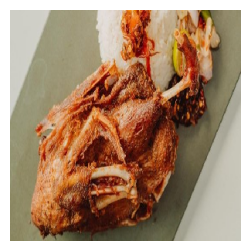

1/1 [==============================] - 2s 2s/step


('Bebek Goreng',
 array([[1.2661064e-03, 2.0187317e-06, 9.9736542e-01, 6.1681235e-06,
         3.5523594e-06, 1.1047589e-03, 1.8292014e-06, 2.1593094e-04,
         2.0370044e-05, 3.3102003e-06, 6.2965664e-06, 4.2527126e-06]],
       dtype=float32))

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

def predict(file):
  model = load_model('/content/drive/MyDrive/model/model_activation_153_v4.h5')

  img_path = '/content/drive/MyDrive/predict/' + file
  img = image.load_img(img_path, target_size=(299, 299))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array / 255.0

  plt.figure(figsize=(3, 3))
  plt.imshow(img)
  plt.axis('off')  # Turn off axis labels
  plt.show()

  class_labels = ["Ayam Bakar", "Bakso", "Bebek Goreng", "Burger",
                  "Gado-Gado", "Gudeg", "Omelette", "Rendang",
                  "Salad", "Sate", "Sayur Asem", "Semur Jengkol"]
  prediction_array = model.predict(img_array)
  prediction_index = np.argmax(prediction_array)
  prediction = class_labels[prediction_index]

  return prediction, prediction_array

predict('bebek_goreng_megawati.jpg')

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('/content/drive/MyDrive/model/InceptionV3_conv2d_178_v1.keras')

img_path = '/content/drive/MyDrive/predict/bebek_goreng_megawati.jpg'
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = model.predict(img_array)
predictions = np.argmax(predictions)

print(predictions)
prediction_index = np.argmax(model.predict(img_array))
  prediction = class_labels[prediction_index]

1/1 [==============================] - 2s 2s/step
2
